In [2]:
import matplotlib.pyplot as plt
import tifffile
import cv2
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [ ]:
for areaID in [11, 15]:
    imgPath = '../../datasets/Vaihingen/Vaihingen_tiff/img/top_mosaic_09cm_area' + str(areaID) + '.tif'
    labelPath = '../../datasets/Vaihingen/Vaihingen_tiff/gt/top_mosaic_09cm_area' + str(areaID) + '.tif'
    predPath = '../results/vaihingen_best/top_mosaic_09cm_area' + str(areaID) + '.png'
    newPredPath = '../results/vaihingen/top_mosaic_09cm_area' + str(areaID) + '.png'


    img = tifffile.imread(imgPath)
    segments = slic(img, n_segments = 3000, compactness = 25)
    ground_truth = tifffile.imread(labelPath)
    pred = cv2.imread(predPath)[...,::-1]
    new_pred = cv2.imread(newPredPath)[...,::-1]

    f, axarr = plt.subplots(1, 3, figsize=(30,30))
    plt.setp(axarr, xticks=[], yticks=[])

    axarr[0].imshow(mark_boundaries(ground_truth, segments, color=(0, 0, 0), mode='thick'))
    axarr[1].imshow(mark_boundaries(pred, segments, color=(1, 0, 0), mode='thick'))
    axarr[2].imshow(mark_boundaries(new_pred, segments, color=(1, 0, 0), mode='thick'))

    plt.show()

(6000, 6000, 3)
(2688, 2688, 3)


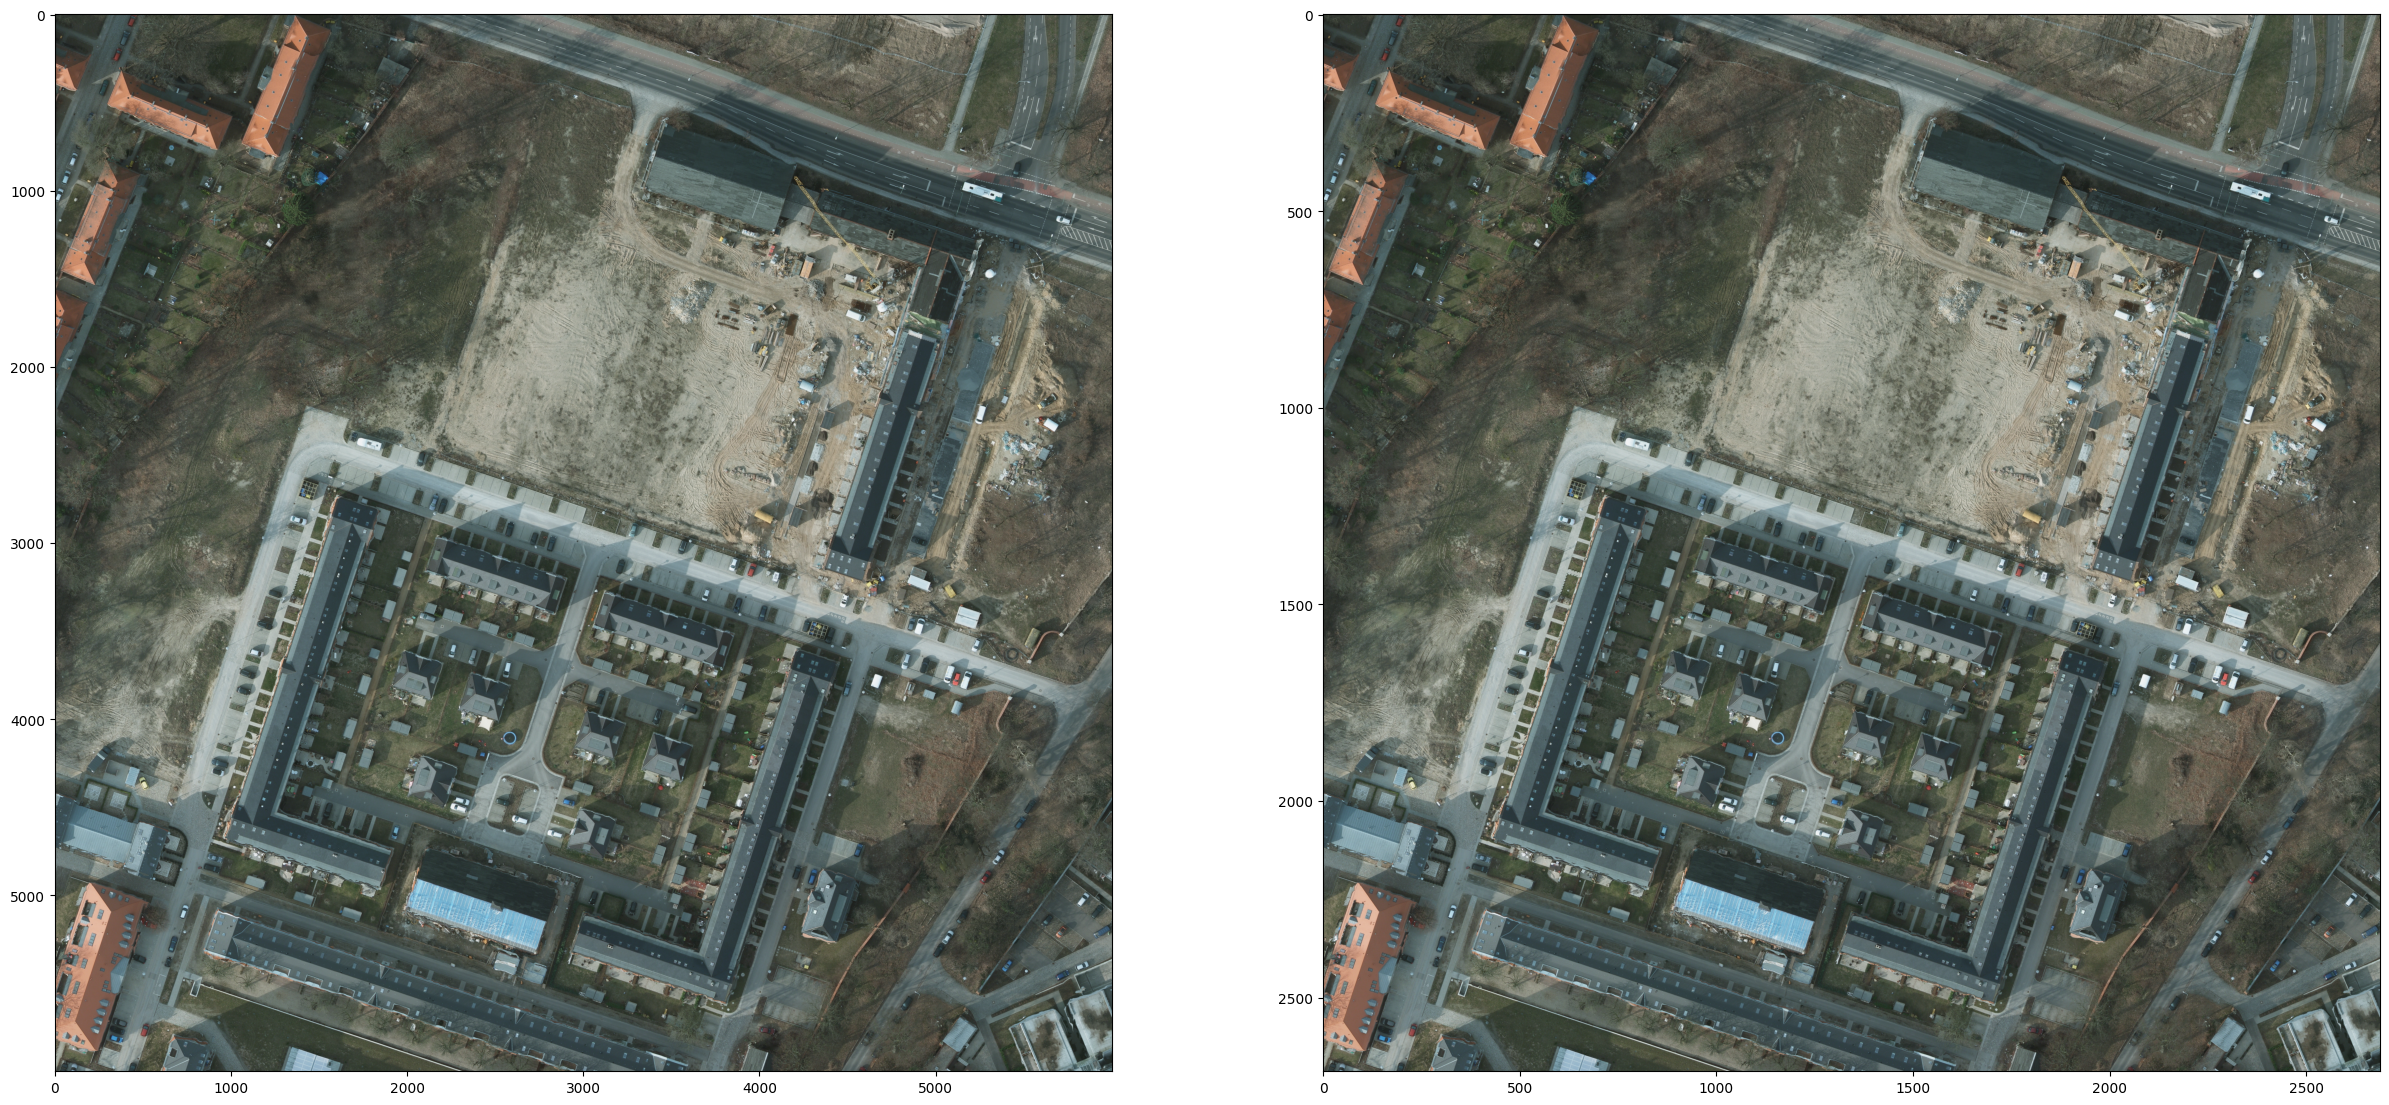

In [6]:
imgPath = '../../datasets/Potsdam/Potsdam_tiff/2_Ortho_RGB/top_potsdam_2_10_RGB.tif'
# labelPath = '../../datasets/Vaihingen/Vaihingen_tiff/gt/top_mosaic_09cm_area' + str(areaID) + '.tif'
# predPath = '../results/vaihingen_best/top_mosaic_09cm_area' + str(areaID) + '.png'
# newPredPath = '../results/vaihingen/top_mosaic_09cm_area' + str(areaID) + '.png'


img = tifffile.imread(imgPath)
# segments = slic(img, n_segments = 3000, compactness = 25)
# ground_truth = tifffile.imread(labelPath)
# pred = cv2.imread(predPath)[...,::-1]
# new_pred = cv2.imread(newPredPath)[...,::-1]

f, axarr = plt.subplots(1, 2, figsize=(30,30))
# plt.setp(axarr, xticks=[], yticks=[])

half = cv2.resize(img, (0, 0), fx = 0.448, fy = 0.448)
print(img.shape)
print(half.shape)
axarr[0].imshow(img)
axarr[1].imshow(half)
# axarr[2].imshow(mark_boundaries(new_pred, segments, color=(1, 0, 0), mode='thick'))

plt.show()

In [ ]:
import os
import sys
import torch
import numpy as np
import cv2 
import tifffile 
from tqdm import tqdm
from skimage.filters.rank import modal
from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from utilities import * 

In [ ]:
loadModelPath = './trainedModels/top_mosaic_09cm_area' + str(1) + '.pth'
if os.path.isfile(loadModelPath):
    model = torch.load(loadModelPath)
    model.cuda()
    model.eval()
    model.requires_grad=False
else:
    sys.exit('Model path not found')   

In [ ]:

areaID = 11
imagePath = '../Vaihingen_tiff/img/top_mosaic_09cm_area' + str(areaID) + '.tif'
labelPath = '../Vaihingen_tiff/gt/top_mosaic_09cm_area' + str(areaID) + '.tif'
baseImageFileName = (os.path.basename(imagePath).rsplit(".", 1))[0]

img = tifffile.imread(imagePath)
# img = cv2.medianBlur(img, 15)

# superpixels = slic(img, n_segments = 2000, compactness = 10)
inputImage = img / 255
# inputImage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# inputImage[:,:,0] = inputImage[:,:,0] / 180
# inputImage[:,:,1] = inputImage[:,:,1] / 255
# inputImage[:,:,2] = inputImage[:,:,2] / 255
ground_truth = convert_from_color(tifffile.imread(labelPath))


##Shape of input image
n_rows, n_cols, _ = inputImage.shape
prediction = np.zeros((n_rows, n_cols)).astype(np.uint8)
patchSize = 800  
overlap = 100  # overlap on all sides of the patch

for r in range(0, n_rows, patchSize):
    for c in range(0, n_cols, patchSize):
    
        if r == 0 and c == 0:
            startingRowIndex = 0
            endingRowIndex = patchSize + overlap
            startingColIndex = 0
            endingColIndex = patchSize + overlap
        elif r == 0:
            startingRowIndex = 0
            endingRowIndex = patchSize + overlap
            startingColIndex = c - overlap
            endingColIndex = min(c + patchSize + overlap, n_cols)
        elif c == 0:
            startingRowIndex = r - overlap
            endingRowIndex = min(r + patchSize + overlap, n_rows)
            startingColIndex = 0
            endingColIndex = patchSize + overlap
        else:
            startingRowIndex = r - overlap
            endingRowIndex = min(r + patchSize + overlap, n_rows)
            startingColIndex = c - overlap
            endingColIndex = min(c + patchSize + overlap, n_cols)
        

        data1 = inputImage[startingRowIndex:endingRowIndex, startingColIndex:endingColIndex, :]
        patch_h, patch_w, _ = data1.shape
        inputToNetData1=torch.from_numpy(data1).permute(2, 0, 1).float().cuda()
        inputToNetData1 = torch.unsqueeze(inputToNetData1, 0)
        
        with torch.no_grad():
            projection1, _ = model(inputToNetData1, inputToNetData1) 
        _, prediction1 = torch.max(projection1, 1)  
        
        ##Obtaining segmentation maps
        prediction1Squeezed = torch.squeeze(prediction1).cpu().numpy().astype(np.uint8)
        prediction1Squeezed = modal(prediction1Squeezed, disk(3))

        if r == 0 and c == 0: 
            prediction[0:patchSize, 0:patchSize] = prediction1Squeezed[0:patchSize, 0:patchSize]
        elif r == 0:
            prediction[0:patchSize, c:min(c + patchSize, n_cols)] = prediction1Squeezed[0:patchSize, overlap:min(overlap + patchSize, patch_w)]   
        elif c == 0:
            prediction[r:min(r + patchSize, n_rows), 0:patchSize] = prediction1Squeezed[overlap:min(overlap + patchSize, patch_h), 0:patchSize] 
        else:
            prediction[r:min(r + patchSize, n_rows), c:min(c + patchSize, n_cols)] = prediction1Squeezed[overlap:min(overlap + patchSize, patch_h), overlap:min(overlap + patchSize, patch_w)]   
            

**VEGETATION**

In [ ]:
temp = np.zeros(img.shape).astype(np.uint8)
ind = np.where(prediction == 2)
temp[ind] = img[ind]
ind = np.where(prediction == 4)
temp[ind] = img[ind]
ind = np.where(prediction == 6)
temp[ind] = img[ind]
# print(img.dtype, temp.dtype)
f, axarr = plt.subplots(1, 2, figsize=(30,30))
# plt.setp(axarr, xticks=[], yticks=[])
axarr[0].imshow(img)
axarr[1].imshow(temp)
axarr[0].grid()
axarr[1].grid()
plt.show()

**BUILDINGS**

In [ ]:
temp = np.zeros(img.shape).astype(np.uint8)
ind = np.where(prediction == 1)
temp[ind] = img[ind]
ind = np.where(prediction == 5)
temp[ind] = img[ind]
# print(img.dtype, temp.dtype)
f, axarr = plt.subplots(1, 2, figsize=(30,30))
# plt.setp(axarr, xticks=[], yticks=[])
axarr[0].imshow(img)
axarr[1].imshow(temp)
axarr[0].grid()
axarr[1].grid()
plt.show()

**SHADOWS**

In [ ]:
# temp = np.zeros(img.shape).astype(np.uint8)
# ind = np.where(prediction == 0)
# temp[ind] = img[ind]
# ind = np.where(prediction == 7)
# temp[ind] = img[ind]

# f, axarr = plt.subplots(1, 2, figsize=(30,30))
# axarr[0].imshow(img)
# axarr[1].imshow(temp)
# axarr[0].grid()
# axarr[1].grid()
# plt.show()

hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
temp = np.zeros(img.shape).astype(np.uint8)
ind = np.where(prediction == 0)
temp[ind] = hsv_img[ind]
ind = np.where(prediction == 7)
temp[ind] = hsv_img[ind]

for i in range(3):
    f, axarr = plt.subplots(1, 2, figsize=(30,30))
    axarr[0].imshow(hsv_img[:,:,i], cmap='gray')
    axarr[1].imshow(temp[:,:,i], cmap='gray')
    axarr[0].grid()
    axarr[1].grid()
    plt.show()

**REMOVING SHADOWS**

In [ ]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
np.min(hsv_img), np.max(hsv_img)

In [ ]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
temp = np.zeros(img.shape).astype(np.uint8)
ind = np.where(prediction == 0)
temp[ind] = hsv_img[ind]
ind = np.where(prediction == 7)
temp[ind] = hsv_img[ind]

plt.imshow(temp[:,:,3])

**ROADS**

In [ ]:
temp = np.zeros(img.shape).astype(np.uint8)
ind = np.where(prediction == 3)
temp[ind] = img[ind]
# print(img.dtype, temp.dtype)
f, axarr = plt.subplots(1, 2, figsize=(30,30))
# plt.setp(axarr, xticks=[], yticks=[])
axarr[0].imshow(img)
axarr[1].imshow(temp)
axarr[0].grid()
axarr[1].grid()
plt.show()

In [ ]:
# for cls in np.unique(prediction):
#     temp = np.zeros(img.shape).astype(np.uint8)
#     ind = np.where(prediction == cls)
#     temp[ind] = img[ind]
#     # print(img.dtype, temp.dtype)
#     f, axarr = plt.subplots(1, 2, figsize=(30,30))
#     # plt.setp(axarr, xticks=[], yticks=[])
#     axarr[0].imshow(img)
#     axarr[1].imshow(temp)
#     axarr[0].grid()
#     axarr[1].grid()
#     plt.title(str(cls))
#     plt.show()